# DS 3000: UG Group Project Part 2

## 2a. Regularized Elastic Net Linear Regression

In [1]:
# Import packages
import polars as pl
import pandas as pd 

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold

### i.-ii. Clean/Preprocess the Data similar to Part1 and calculate the target variable. NOTE: If 'HSHNIAGG' value was 0, we set to 1 to avoid division by zero when we calculate the target.

In [2]:
# Load datasets
demo = pd.read_csv("DemoStats.csv")
spend = pd.read_csv("HouseholdSpend.csv")

# Display basic info
print("DemoStats shape:", demo.shape)
print("HouseholdSpend shape:", spend.shape)
print("\nDemoStats preview:\n", demo.head())
print("\nHouseholdSpend preview:\n", spend.head())

# Check for a shared key column
print("\nCommon columns:", set(demo.columns).intersection(set(spend.columns)))

DemoStats shape: (868970, 736)
HouseholdSpend shape: (868970, 246)

DemoStats preview:
      CODE     GEO  ECYASQKM  ECYALSQKM  ECYBASPOP  ECYBASHHD  ECYBASHPOP  \
0  A0A0A0  FSALDU         0          0          0          0           0   
1  A0A1A0  FSALDU         0          0         55         33          55   
2  A0A1B0  FSALDU         0          0        588        243         588   
3  A0A1C0  FSALDU         0          0       1793        709        1791   
4  A0A1E0  FSALDU         0          0        452        176         449   

   ECYBAS12P  ECYBAS15P  ECYBAS18P  ...  ECYGEN1GEN  ECYGEN2GEN  ECYGEN3GEN  \
0          0          0          0  ...           0           0           0   
1         55         55         55  ...           0           0          55   
2        561        512        475  ...          11          14         563   
3       1548       1465       1405  ...          50          32        1709   
4        415        389        357  ...          10         

In [3]:
# Merge on common columns
data = pd.merge(demo, spend, on=["CODE", "GEO"], how="inner")

# Drop identifier columns
data = data.drop(columns=["CODE", "GEO"])
data.shape

(868970, 978)

In [4]:
# Check for non-numerical columns
non_numerical_cols = len(data.select_dtypes(exclude=['number']).columns)
print(f'Found {non_numerical_cols} non-numerical columns.\n')

# Columns with at least one null
null_columns = data.columns[data.isnull().any()]

# Total number of rows
total_rows = len(data)

# Count nulls and percent nulls
null_counts = data[null_columns].isnull().sum()
null_percent = null_counts / total_rows * 100

# Percent of non-null rows that are zero
zero_percent = (data[null_columns] == 0).sum() / data[null_columns].notnull().sum() * 100

# Combine all into one DataFrame
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Percent Nulls': null_percent,
    'Percent Zeros': zero_percent
})

print(null_summary)

Found 0 non-numerical columns.

           Null Count  Percent Nulls  Percent Zeros
ECYPTAMED       87459      10.064674            0.0
ECYPMAMED       96444      11.098657            0.0
ECYPFAMED      131837      15.171640            0.0
ECYHTAMED       92709      10.668838            0.0
ECYHMAMED      101698      11.703281            0.0
ECYHFAMED      137900      15.869363            0.0
ECYMTNMED       92709      10.668838            0.0


There are seven columns with large amounts of null values, but not large enough to simply drop them right away. Let's decide whether to drop them or not based on whether they show any correlation with the target variable.

In [5]:
################################
# Avoid division by zero
data.loc[data['HSHNIAGG'] == 0, 'HSHNIAGG'] = 1

# Create target variable
data["target"] = data["HSEP001S"] / data["HSHNIAGG"]
#################################

# Create target variable
temp_df = pd.DataFrame()
temp_df["target"] = data["HSEP001S"] / data["HSHNIAGG"]

# Compare variables with null values
cols_to_compare = data[['ECYPTAMED', 'ECYPMAMED', 'ECYPFAMED',
                        'ECYHTAMED', 'ECYHMAMED', 'ECYHFAMED', 'ECYMTNMED']]

# Calculate correlation with target
correlations = cols_to_compare.corrwith(temp_df['target']).dropna()
correlation_table = correlations.sort_values(key=abs, ascending=False).reset_index()
correlation_table.columns = ['Variable', 'Correlation with Target']

print(correlation_table.to_string(index=False))

 Variable  Correlation with Target
ECYMTNMED                -0.524898
ECYPTAMED                -0.340433
ECYPFAMED                -0.317904
ECYHTAMED                -0.299881
ECYHFAMED                -0.290344
ECYPMAMED                -0.272607
ECYHMAMED                -0.229441


All of the columns with null values seem to have meaningfuly enough correlation with the target such that we should keep them and impute the null values. Let's do that next.


In [6]:
# Creates dict of the column names and the median of the column
dict_median = {column: data[column].median() for column in null_columns}
print(dict_median)

# Replace the NA/NaN values with the median of the column
data.fillna(value=dict_median, inplace=True)

{'ECYPTAMED': 41.3, 'ECYPMAMED': 40.0, 'ECYPFAMED': 42.5, 'ECYHTAMED': 41.1, 'ECYHMAMED': 40.0, 'ECYHFAMED': 42.5, 'ECYMTNMED': 55.0}


Now we will read the metadata files to find any variables related to the target variables, including the target variables themselves and save them for dropping in order to prevent data leakage.

In [7]:
household_meta = pd.read_csv("Documentation/HouseholdSpend 2024 - Metadata.csv")
demostats_meta = pd.read_csv("Documentation/DemoStats 2024 - Metadata.csv")

# Define keywords
keywords = ['insurance', 'pension', 'retirement', 'income tax', 'income', "RRIF"]

# Filter by keyword in description
def find_related_vars(df, desc_col='Description', var_col='Variable'):
    # Match keyword in description
    mask = df[desc_col].str.lower().str.contains('|'.join(keywords), na=False)
    related = df[mask].copy()
    related_vars = related[var_col].unique()

    # Include derived variables by prefix match
    derived_mask = df[var_col].apply(lambda x: any(str(x).startswith(prefix) for prefix in related_vars))
    derived = df[derived_mask]

    # Combine and filter columns
    combined = pd.concat([related, derived]).drop_duplicates()
    return combined[['Variable', 'Description', 'Category', 'Root Formula']]

# Find matching variables
demo_related = find_related_vars(demostats_meta)
spend_related = find_related_vars(household_meta)

# Extract variable names for dropping
drop_vars = list(demo_related['Variable'].unique()) + list(spend_related['Variable'].unique())
drop_vars = [str(var).strip() for var in drop_vars]

print("\nTotal variables marked for dropping:", len(drop_vars))
print("Variable names:\n", drop_vars)



Total variables marked for dropping: 176
Variable names:
 ['EHYHRI_020', 'EHYHRI2040', 'EHYHRI4060', 'EHYHRI6080', 'EHYHRIX100', 'EHYHRI100P', 'EHYHRIX125', 'EHYHRIX150', 'EHYHRIX200', 'EHYHRI200P', 'EHYHRIX300', 'EHYHRI300P', 'EHYHRIAVG', 'EHYHRIMED', 'EHYHRIAGG', 'EHYHNI_020', 'EHYHNI2040', 'EHYHNI4060', 'EHYHNI6080', 'EHYHNIX100', 'EHYHNI100P', 'EHYHNIX125', 'EHYHNIX150', 'EHYHNIX200', 'EHYHNI200P', 'EHYHNIX300', 'EHYHNI300P', 'EHYHNIAVG', 'EHYHNIMED', 'EHYHNIAGG', 'ECYHRI_020', 'ECYHRI2040', 'ECYHRI4060', 'ECYHRI6080', 'ECYHRIX100', 'ECYHRI100P', 'ECYHRIX125', 'ECYHRIX150', 'ECYHRIX200', 'ECYHRI200P', 'ECYHRIX300', 'ECYHRI300P', 'ECYHRIAVG', 'ECYHRIMED', 'ECYHRIAGG', 'ECYHNI_020', 'ECYHNI2040', 'ECYHNI4060', 'ECYHNI6080', 'ECYHNIX100', 'ECYHNI100P', 'ECYHNIX125', 'ECYHNIX150', 'ECYHNIX200', 'ECYHNI200P', 'ECYHNIX300', 'ECYHNI300P', 'ECYHNIAVG', 'ECYHNIMED', 'ECYHNIAGG', 'ECYPNIHP15', 'ECYPNININ', 'ECYPNIWIN', 'ECYPNIAVG', 'ECYINDFINA', 'P3YHRI_020', 'P3YHRI2040', 'P3YHRI4060', 'P3

We've found 176 variables that are related to the target variables, many of which are demographic statistics that would allow the target variables to be reverse engineered, at least to some degree. So let's drop these variables, but note that the actual provied data does not actually include all these variables since the metadata file and the actual data are out of sync, as explained by TAs already. Let's just note the ones that we didn't find in the data and then remove the ones that we did find!


In [8]:
found = [col for col in drop_vars if col in data.columns]
missing = [col for col in drop_vars if col not in data.columns]

print(f"\nFound {len(found)} of {len(drop_vars)} drop_vars in the data.")
print("Examples not found:", missing[:10])

before_cols = data.shape[1]
# Drop columns
data = data.drop(columns=[col for col in drop_vars if col in data.columns])
after_cols = data.shape[1]

print(f"\nDropped {before_cols - after_cols} columns from data.")


Found 47 of 176 drop_vars in the data.
Examples not found: ['EHYHRI_020', 'EHYHRI2040', 'EHYHRI4060', 'EHYHRI6080', 'EHYHRIX100', 'EHYHRI100P', 'EHYHRIX125', 'EHYHRIX150', 'EHYHRIX200', 'EHYHRI200P']

Dropped 47 columns from data.


In [9]:
data.shape

(868970, 932)

Finally, we want to check for outliers in the columns, for each outlier we find outside the IQR range, we will set it to the lower and upper bound of the IQR respectively. We chose IQR here because the z-score clipping method is sensitive to datasets that are very skewed and since we don't know all the details about how skewed and strong the outliers in this dataset are, it's better to be conservative and just use the robust IQR method.

In [10]:
# IQR-based winsorization
for col in data.select_dtypes(include='number').columns:
    if col == 'target': # target will be excluded from winsorization
        continue
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower, upper=upper)

print("Outliers have been capped using IQR method (1.5 * IQR).")

Outliers have been capped using IQR method (1.5 * IQR).


Outliers have been capped using IQR method (1.5 * IQR).

Finally, we will remove columns with very low variance (essentially repeated data and noise), and then scale the data.


In [11]:
# Drop columns with all same values (including all zeros)
low_variance_cols = data.columns[data.nunique() <= 1]
data = data.drop(columns=low_variance_cols)
print(f"Dropped {len(low_variance_cols)} low-variance columns.")

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Output shape of cleaned and scaled data
print("Final cleaned shape:", data_scaled_df.shape)

Dropped 304 low-variance columns.
Final cleaned shape: (868970, 628)


In [12]:
# Train test split
X = data_scaled_df.drop(columns="target")
y = data_scaled_df["target"]

# Using random_state = 9 (as in group number 9) for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

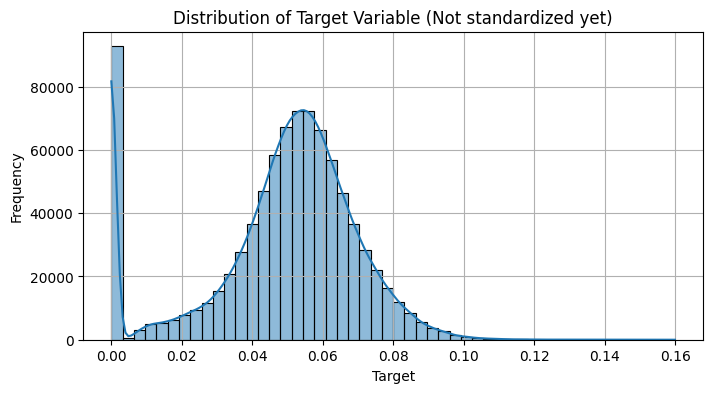

Skewness of target: -0.736


In [13]:
import seaborn as sns
from scipy.stats import skew

# Check target distribution
target = data['target']

# Plot histogram with KDE (density curve)
plt.figure(figsize=(8, 4))
sns.histplot(target, bins=50, kde=True)
plt.title("Distribution of Target Variable (Not standardized yet)")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Print skewness value
print(f"Skewness of target: {skew(target):.3f}")

### iii. Grid search for parameters

In [14]:
# Parameter Grid
# param_grid = {
#     'enet__alpha': [0.001, 0.01, 0.1],
#     'enet__l1_ratio': [0.1, 0.2]    
# }
alphas = [0.01, 0.05, 0.1]
l1_ratios = [0.1, 0.3, 0.5]

enetcv = ElasticNetCV(
    l1_ratio=l1_ratios, # l1 ratio grid
    alphas=alphas,
    cv=3, # 3 CV
    max_iter=10000,
    n_jobs=1,
    verbose=0
)

# Run the grid search on enet
enetcv.fit(X_train, y_train)

ElasticNetCV(alphas=[0.01, 0.05, 0.1], cv=3, l1_ratio=[0.1, 0.3, 0.5],
             max_iter=10000, n_jobs=1)

One objective did not converge but rest of them did: Very good fit.

In [15]:
# Report best params
best_alpha = enetcv.alpha_
best_l1_ratio = enetcv.l1_ratio_

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

Best alpha: 0.01
Best l1_ratio: 0.1


Explanation: 

### iv. Scatterplots, MSE, and R2

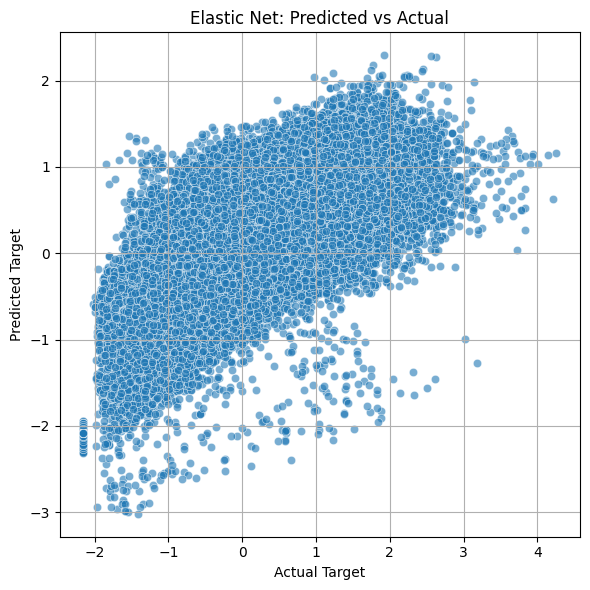

In [16]:
# Predict on the best model with test set
y_pred = enetcv.predict(X_test)

# Display figure
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Target")
plt.ylabel("Predicted Target")
plt.title("Elastic Net: Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# MSE and R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")

# Bootstrap
n_bootstraps = 1000
bootstrapped_mse = np.zeros(n_bootstraps)
bootstrapped_r2 = np.zeros(n_bootstraps)

# Convert to numpy arrays for easier indexing
y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)

for i in range(n_bootstraps):
    # Get the indices for the bootstrap sample
    idx = np.random.choice(len(y_test_np), size=len(y_test_np), replace=True)
    
    # Get the MSE of the bootstrap sample
    bootstrapped_mse[i] = mean_squared_error(y_test_np[idx], y_pred_np[idx])

    # Get the r2 of the bootstrap sample
    bootstrapped_r2[i] = r2_score(y_test_np[idx], y_pred_np[idx])

mse_diff = bootstrapped_mse - mse
r2_diff = bootstrapped_r2 - r2

# Calculate the 95% CI for MSE and R2
mse_ci = np.percentile(mse_diff, [2.5, 97.5])
r2_ci = np.percentile(r2_diff, [2.5, 97.5])

# Center the intervals around original value
print(f"The 95% confidence interval for the MSE is [{(mse - mse_ci[1]):.4f}, {(mse - mse_ci[0]):.4f}]")
print(f"The 95% confidence interval for the R2 is [{(r2 - r2_ci[1]):.4f}, {(r2 - r2_ci[0]):.4f}]")


MSE: 0.1966
R2: 0.8040
The 95% confidence interval for the MSE is [0.1948, 0.1983]
The 95% confidence interval for the R2 is [0.8020, 0.8058]


### v. Top 5 most important variables

In [18]:
# Extract coefficients
coefs = enetcv.coef_
features = X_train.columns

# Create dataframe
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefs
})

# Sort by Abs value to find most important variables
top5 = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(5)

print("Top 5 most important variables:")
print(top5)

Top 5 most important variables:
       Feature  Coefficient
265   ECYACTER     0.606152
266   ECYACTUR     0.398349
147  ECYMTNMED    -0.224291
146  ECYMTNAVG    -0.205976
412   HSME001S     0.174283


Interpret:

## 2b. XGB

### i. Data Preparation

Using the Same Data as Part 2b.

### ii. Parameter Grid and XGB

In [19]:
# Define the hyperparameter grid for XGBoost
param_grid_xgb = {
    "n_estimators":[100, 150, 200], 
    "max_depth":[2, 3, 5], 
    "learning_rate":[0.01, 0.1]}

# Initialize the XGBoost regressor
XGB_Placement = XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree',
    verbosity=0,
    tree_method='hist', 
    device='cuda',        # Enable GPU Acceleration
    n_jobs=1,            
    gamma=0.001,
    subsample=0.632,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    base_score=0.5
)

# 3 fold CV object for grid search
cv_obj = KFold(n_splits = 3, shuffle = True)

# Apply Grid Search only for Random Forest
GridXGB = GridSearchCV(
    XGB_Placement, param_grid_xgb, cv=cv_obj, scoring='neg_mean_squared_error', verbose=1, n_jobs=1
)

# Train the model
GridXGB.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    device='cuda', early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=0.001, grow_policy=None,
                                    impor...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=1, num_parallel_tree=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [2, 3, 5],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [20]:
print("Best parameters from XGBoost GridSearch:")
print(GridXGB.best_params_)

Best parameters from XGBoost GridSearch:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


### iii. Scatterplot and Performance Measures

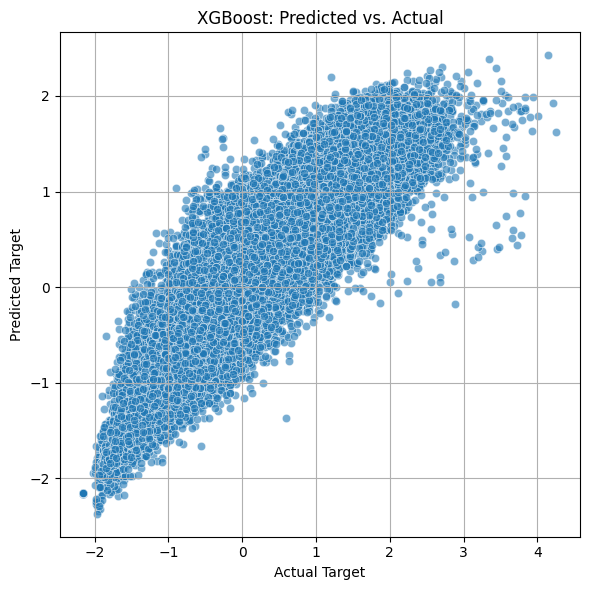

In [21]:
# Test with best model
y_pred_xgb = GridXGB.predict(X_test)

# Scatterplot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.xlabel("Actual Target")
plt.ylabel("Predicted Target")
plt.title("XGBoost: Predicted vs. Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# MSE and R2
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Bootstrap
n_bootstraps = 1000
bootstrapped_mse_xgb = np.zeros(n_bootstraps)
bootstrapped_r2_xgb = np.zeros(n_bootstraps)

# Convert to numpy arrays for easier indexing
y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred_xgb)

for i in range(n_bootstraps):
    # Get the indices for the bootstrap sample
    idx = np.random.choice(len(y_test_np), size=len(y_test_np), replace=True)
    
    # Get the MSE of the bootstrap sample
    bootstrapped_mse_xgb[i] = mean_squared_error(y_test_np[idx], y_pred_np[idx])

    # Get the r2 of the bootstrap sample
    bootstrapped_r2_xgb[i] = r2_score(y_test_np[idx], y_pred_np[idx])

mse_diff_xgb = bootstrapped_mse_xgb - mse_xgb
r2_diff_xgb = bootstrapped_r2_xgb - r2_xgb

# Calculate the 95% CI for MSE and R2
mse_xgb_ci = np.percentile(mse_diff_xgb, [2.5, 97.5])
r2_xgb_ci = np.percentile(r2_diff_xgb, [2.5, 97.5])

# Center values
print(f"MSE: {mse_xgb:.4f}")
print(f"R2: {r2_xgb:.4f}")

# Center the intervals around original value
print(f"The 95% confidence interval for the MSE is [{(mse_xgb - mse_xgb_ci[1]):.4f}, {(mse_xgb - mse_xgb_ci[0]):.4f}]")
print(f"The 95% confidence interval for the R2 is [{(r2_xgb - r2_xgb_ci[1]):.4f}, {(r2_xgb - r2_xgb_ci[0]):.4f}]")

MSE: 0.0888
R2: 0.9114
The 95% confidence interval for the MSE is [0.0880, 0.0896]
The 95% confidence interval for the R2 is [0.9105, 0.9123]


## 2c. SHAP

In [23]:
import shap

# Get the best trained XGB model 
best_xgb = GridXGB.best_estimator_

# Create SHAP explainer
explainer = shap.Explainer(best_xgb, X_test)

# Compute SHAP values 
shap_values = explainer(X_test)

# Calculate mean absolute SHAP values for ranking
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_names = X_test.columns

# Create a datafrae for ranks
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'MeanAbsSHAP': mean_abs_shap
}).sort_values(by='MeanAbsSHAP', ascending=False)

# Get top 5 features
top5_shap = shap_df.head(5)
print("Top 5 most important variables by SHAP:")
print(top5_shap)

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 260609/260691 [23:26<00:00]        

Top 5 most important variables by SHAP:
       Feature  MeanAbsSHAP
503    HSHO002     0.136793
481    HSSH042     0.128738
413   HSMG001S     0.125080
147  ECYMTNMED     0.101050
522    HSCC002     0.083168


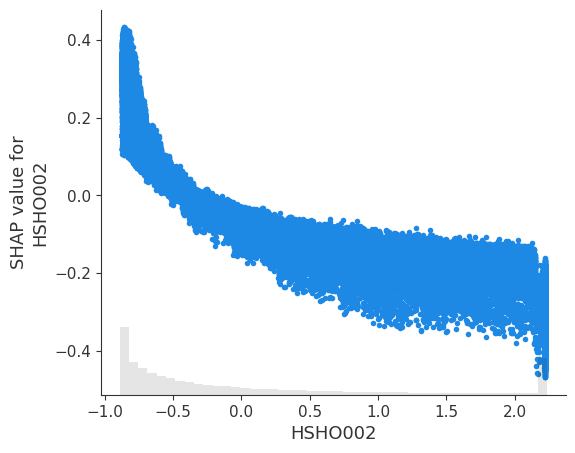

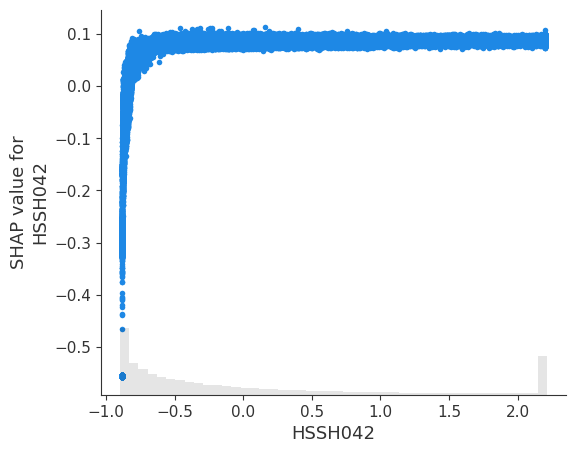

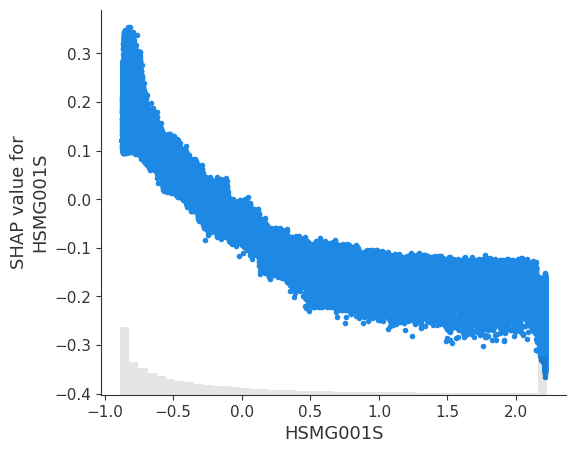

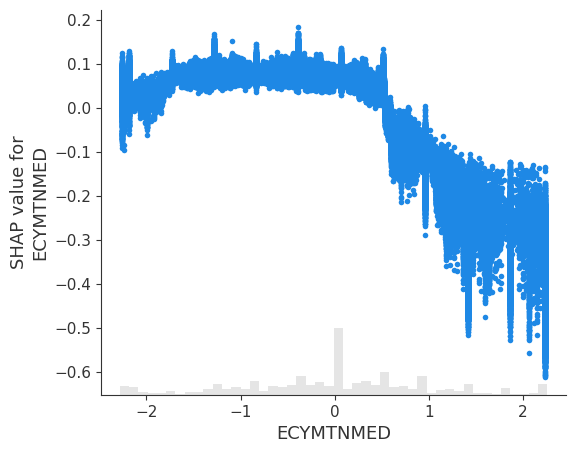

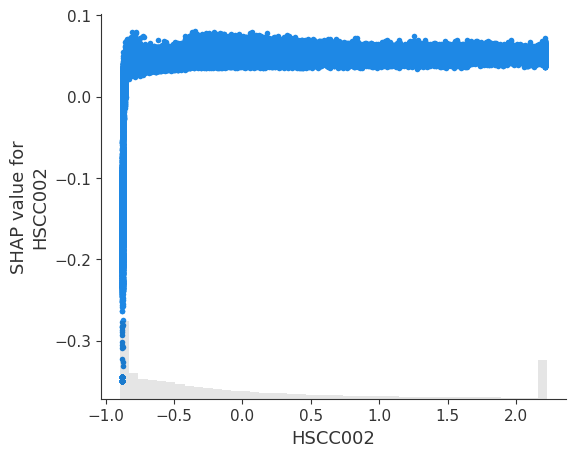

In [24]:
# Dependence plots for top 5 features
for feature in top5_shap['Feature']:
    shap.plots.scatter(shap_values[:, feature])